# Combined number of scans for all spheroids

In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
from pp_utils.core import generate_data_path_dict
from pp_utils.file_handling import df_main_loader
from pp_utils import utils, utils_plot

In [3]:
import pickle

## Set paths, load main info df and clusters

In [4]:
data_path = generate_data_path_dict(Path("../data_processed/"))
raw_path = Path("../data_raw/")

### Data and output path

In [5]:
output_path = data_path["main"] / "data_summary"
tp_path = output_path / "trial_processor_object"

In [6]:
fig_path = Path("../figs")
if not fig_path.exists():
    fig_path.mkdir()

In [7]:
stat_path = Path("../stat")

### Load main dataframe

In [8]:
df_main = df_main_loader(
    folder=data_path["info_csv"], filename="main_info_append_09.csv",
)

### Load compiled trial info

In [9]:
df_summary = pd.read_csv(output_path / "data_summary_all.csv", index_col=0)

In [10]:
df_summary["TRIAL_TO_INCLUDE"] = df_main["TRIAL_TO_INCLUDE"]

In [11]:
df_summary["TCCT"] = df_main["LEFT"] + df_main["RIGHT"]

## Spheroid names and colors

In [12]:
SPH_COLORS = ["w", "gainsboro", "darkgrey"]  # L, M, S

In [13]:
SPH_STR = ["L", "M", "S"]
SPH_LABEL = ["AR=2.9", "AR=1.3", "AR=1.1"]

In [14]:
sph_tcct = [f"{sph}_{tcct_type}" for sph, tcct_type in zip(["L", "M", "S"]*2, ["TC"]*3+["CT"]*3)]

In [15]:
sph_tcct

['L_TC', 'M_TC', 'S_TC', 'L_CT', 'M_CT', 'S_CT']

## Assemble plot

In [16]:
scan_bins = np.arange(0, 27) - 0.5
scan_x = (scan_bins[:-1] + scan_bins[1:])/2
scan_bar_width = 0.25

In [17]:
# Vertical shift for CT clusters
vert_shift = 0.4

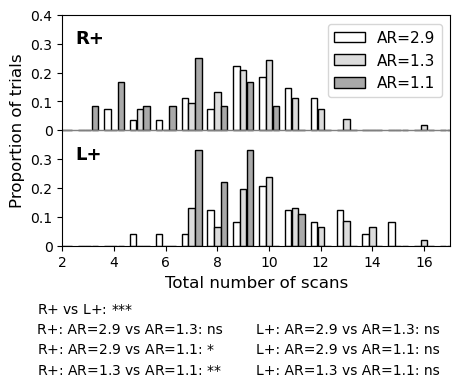

In [18]:
fig, ax_sph = plt.subplots(1, 1, figsize=(5, 3), facecolor="w")


# Different spheroids
for sph_seq, sph in enumerate(["L", "M", "S"]):
    
    for tcct_type in ["TC", "CT"]:

        # CT trials -- TOP panel
        sph_index = (
        (df_summary["SPHEROID"] == sph)
            & (df_summary["CHOICE"] == 1)
            & df_summary["TRIAL_TO_INCLUDE"]
            & (df_summary["TCCT"] == tcct_type)
        )
        df_wanted = df_summary[sph_index].copy()
        ta, _ = np.histogram(df_wanted["scan_combined"]-1, bins=scan_bins, density=True)

        # Horiztonal bar shift
        if sph_seq == 0:
            shift = -scan_bar_width-0.01 # if L shift bar leftward
        elif sph_seq == 2:
            shift = scan_bar_width+0.01  # if S shift bar rightward
        else:
            shift = 0  # if M does not shift

        bottom = 0 if tcct_type=="CT" else vert_shift  # vertical shift
        ax_sph.bar(
            scan_x + shift, ta, bottom=bottom, width=scan_bar_width, 
            alpha=1, color=SPH_COLORS[sph_seq], edgecolor="k"
        )

# Horizontal divide line
ax_sph.axhline(vert_shift, color="grey", lw=1)
    

ax_sph.set_xlim(0, 12)
ax_sph.set_xticks(np.arange(0, 13, 2))
ax_sph.set_xticklabels(np.arange(0, 13, 2), fontsize=12)
ax_sph.set_yticks(np.array([0, 0.25, 0.5, vert_shift, vert_shift+0.25, vert_shift+0.5]))
ax_sph.set_yticklabels([0, 0.25, 0.5, 0, 0.25, 0.5], fontsize=12)
ax_sph.set_ylim(0, vert_shift*2)


# Axis labels
ax_sph.set_ylim(0, 0.25)
ax_sph.set_yticks(np.arange(0, 0.85, 0.1))
ax_sph.set_yticklabels([0, 0.1, 0.2, 0.3, 0, 0.1, 0.2, 0.3, 0.4], fontsize=10)

ax_sph.set_xticks(np.arange(0, 25, 2))
ax_sph.set_xticklabels(np.arange(0, 25, 2), fontsize=10)
ax_sph.set_xlim(2, 17)

ax_sph.set_xlabel("Total number of scans", fontsize=12)
ax_sph.set_ylabel("Proportion of trials", fontsize=12)



# Plot legend
ax_sph.text(2.5, 0.7, "R+", fontsize=13, fontweight="bold")
ax_sph.text(2.5, 0.3, "L+", fontsize=13, fontweight="bold")


ax_sph_pos = ax_sph.get_position()

ax_sph_mock = plt.axes(ax_sph.get_position())
ax_sph_mock.patch.set_alpha(0)
plt.axis("off")
for seq in range(3):
    ax_sph_mock.bar(np.nan, np.nan,
        edgecolor="k", color=SPH_COLORS[seq], label=SPH_LABEL[seq])
ax_sph_mock.legend(
    bbox_to_anchor=(12, 0.49), bbox_transform=ax_sph.transData,
    fontsize=11, loc="lower left"
)


# Stats annotation
df_stat_position = pd.read_csv(stat_path / f"ARall_S3_scan_position_contrast.csv")
df_stat_spheroid = pd.read_csv(stat_path / f"ARall_S3_scan_spheroid_contrast.csv")
utils_plot.annotate_p_val_scan(
    ax_sph, df_stat_position, df_stat_spheroid, group="spheroid", ratio=False,
    horz_text_left=1, horz_text_right=9.5,
    vert_text_gap=0.07, vert_text=-0.22,
    fontsize=10,
)





plt.show()

fig.savefig(fig_path / "fig_combined_scan_allAR.png", dpi=300, bbox_inches="tight")
